In [61]:
import numpy as np 
import pandas as pd 
import os
import pathlib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import warnings
warnings.filterwarnings('ignore')
os.environ["KMP_WARNINGS"] = "FALSE"

In [51]:
from sqlalchemy import create_engine
from config import db_password, end
db_string = f"postgresql://postgres:{db_password}@{end}:5432/postgres"

engine = create_engine(db_string)

connection = engine

In [52]:
pd.read_sql("SELECT * FROM sports", connection)

,filepaths,labels,data_set,bins
0,train/air hockey/001.jpg,air hockey,train,disc
1,train/air hockey/002.jpg,air hockey,train,disc
2,train/air hockey/003.jpg,air hockey,train,disc
3,train/air hockey/004.jpg,air hockey,train,disc
4,train/air hockey/005.jpg,air hockey,train,disc
...,...,...,...,...
14567,valid/wingsuit flying/1.jpg,wingsuit flying,valid,Extreme Sports
14568,valid/wingsuit flying/2.jpg,wingsuit flying,valid,Extreme Sports
14569,valid/wingsuit flying/3.jpg,wingsuit flying,valid,Extreme Sports
14570,valid/wingsuit flying/4.jpg,wingsuit flying,valid,Extreme Sports


In [2]:
# Set Parameters
num_classes = 100
batch_size = 100
img_height = 224
img_width = 224

In [3]:
# Dataset came with train, valid, test already in place.
# Keras data loader
# training, validation and test set
TRAIN_PATH = pathlib.Path("train")
VAL_PATH = pathlib.Path("valid")
TEST_PATH = pathlib.Path("test")

train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_PATH,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
    VAL_PATH,
    image_size=(img_height, img_width),
    batch_size=batch_size)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_PATH,
    image_size=(img_height, img_width),
    batch_size=batch_size)  

Found 1667 files belonging to 100 classes.
Found 500 files belonging to 100 classes.
Found 500 files belonging to 100 classes.


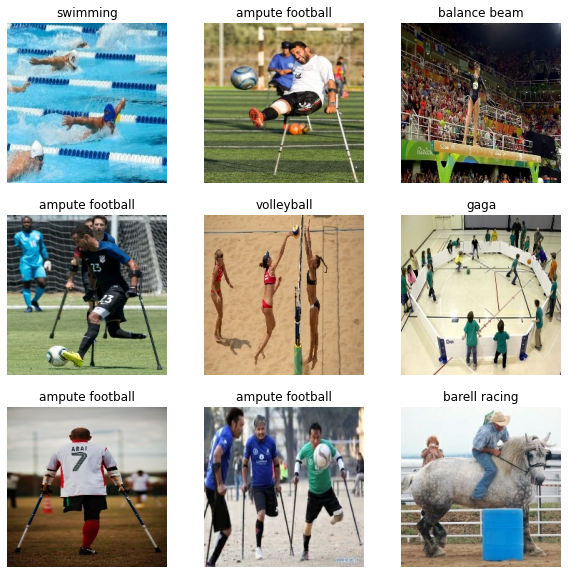

In [19]:
# Show images from train dataset
class_names = train_ds.class_names
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

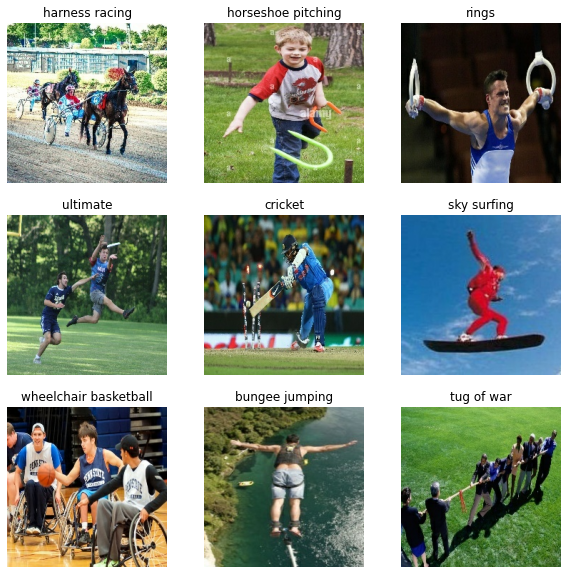

In [6]:
# Show images from valid dataset
class_names = val_ds.class_names
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [12]:
# Chose to use a sequential machine learning model to layer down the images.
model1 = Sequential([
    layers.Rescaling(1./255),
    layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(256, (3,3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(512, (3,3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(512, (3,3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(num_classes)
])

# setting hyperparameters
model1.compile(optimizer='adam', # set the optimizer
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # loss function
    metrics=['accuracy']) #accuracy metric
history = model1.fit(train_ds,epochs=10, validation_data=val_ds)
print("PERFOMANCE",model1.evaluate(test_ds))
model1.summary()

Epoch 1/10
17/17 [==============================] - 126s 7s/step - loss: 4.1887 - accuracy: 0.0822 - val_loss: 5.1263 - val_accuracy: 0.0160
Epoch 2/10
17/17 [==============================] - 129s 8s/step - loss: 3.5083 - accuracy: 0.0960 - val_loss: 5.1022 - val_accuracy: 0.0100
Epoch 3/10
17/17 [==============================] - 130s 8s/step - loss: 3.3706 - accuracy: 0.1260 - val_loss: 5.2882 - val_accuracy: 0.0200
Epoch 4/10
17/17 [==============================] - 130s 8s/step - loss: 3.2531 - accuracy: 0.1668 - val_loss: 5.2214 - val_accuracy: 0.0320
Epoch 5/10
17/17 [==============================] - 132s 8s/step - loss: 3.1236 - accuracy: 0.2226 - val_loss: 5.4881 - val_accuracy: 0.0440
Epoch 6/10
17/17 [==============================] - 134s 8s/step - loss: 2.9825 - accuracy: 0.2561 - val_loss: 4.9578 - val_accuracy: 0.0340
Epoch 7/10
17/17 [==============================] - 132s 8s/step - loss: 2.8096 - accuracy: 0.3101 - val_loss: 4.6554 - val_accuracy: 0.0380
Epoch 8/10
17

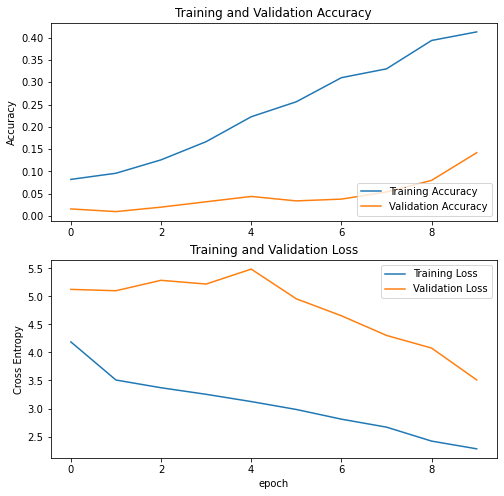

In [13]:
# plot training history from custom sequential model
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [22]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image

In [55]:
BATCH_SIZE = 64
IMAGE_SIZE = (img_height, img_width)


train_data_generator = image.ImageDataGenerator(horizontal_flip=True, preprocessing_function=preprocess_input)

test_data_generator = image.ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_data_generator.flow_from_directory(directory= TRAIN_PATH,
                                                    target_size=IMAGE_SIZE,
                                                    color_mode= 'rgb',
                                                    class_mode= 'categorical',
                                                    batch_size= BATCH_SIZE)

val_generator = test_data_generator.flow_from_directory(directory= VAL_PATH,
                                                    target_size=IMAGE_SIZE,
                                                    color_mode= 'rgb',
                                                    class_mode= 'categorical',
                                                    batch_size= BATCH_SIZE)

test_generator = test_data_generator.flow_from_directory(directory= TEST_PATH,
                                                    target_size=IMAGE_SIZE,
                                                    color_mode= 'rgb',
                                                    class_mode= 'categorical',
                                                    batch_size= BATCH_SIZE)

Found 1667 images belonging to 100 classes.
Found 500 images belonging to 100 classes.
Found 500 images belonging to 100 classes.


In [25]:
# Building a transfer model from MobileNetV2 to see if it can give us better accuracy.

base = MobileNetV2(weights='imagenet', include_top=False)
base.trainable = False

model = Sequential([
    base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(num_classes)
])

model.compile(
    optimizer="adam",
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

model.summary()

#Train model
history = model.fit(train_generator, validation_data=val_generator, epochs=5)
print("PERFOMANCE",model.evaluate(test_generator))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, None, None, 1280)  2257984  
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0

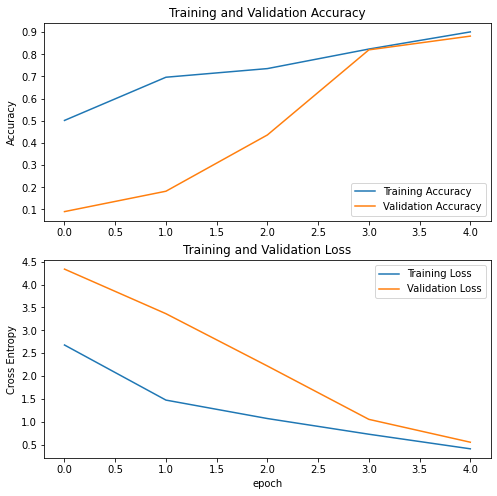

In [17]:
# plot training history from transfer sequential model
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [56]:
test_score = model.evaluate_generator(test_generator, batch_size)
print("[INFO] accuracy: {:.2f}%".format(test_score[1] * 100))
print("[INFO] Loss: ",test_score[0])

[INFO] accuracy: 57.20%
[INFO] Loss:  1.6801464557647705


Confusion Matrix
Classification Report
                       precision    recall  f1-score   support

           air hockey       0.00      0.00      0.00         5
      ampute football       0.00      0.00      0.00         5
              archery       0.00      0.00      0.00         5
        arm wrestling       0.00      0.00      0.00         5
         axe throwing       0.00      0.00      0.00         5
         balance beam       0.00      0.00      0.00         5
        barell racing       0.00      0.00      0.00         5
             baseball       0.00      0.00      0.00         5
           basketball       0.04      0.20      0.06         5
       baton twirling       0.00      0.00      0.00         5
            bike polo       0.12      0.20      0.15         5
            billiards       0.33      0.20      0.25         5
                  bmx       0.00      0.00      0.00         5
              bobsled       0.00      0.00      0.00         5
              b

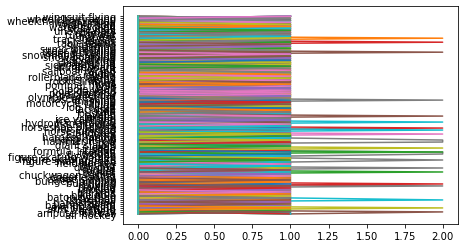

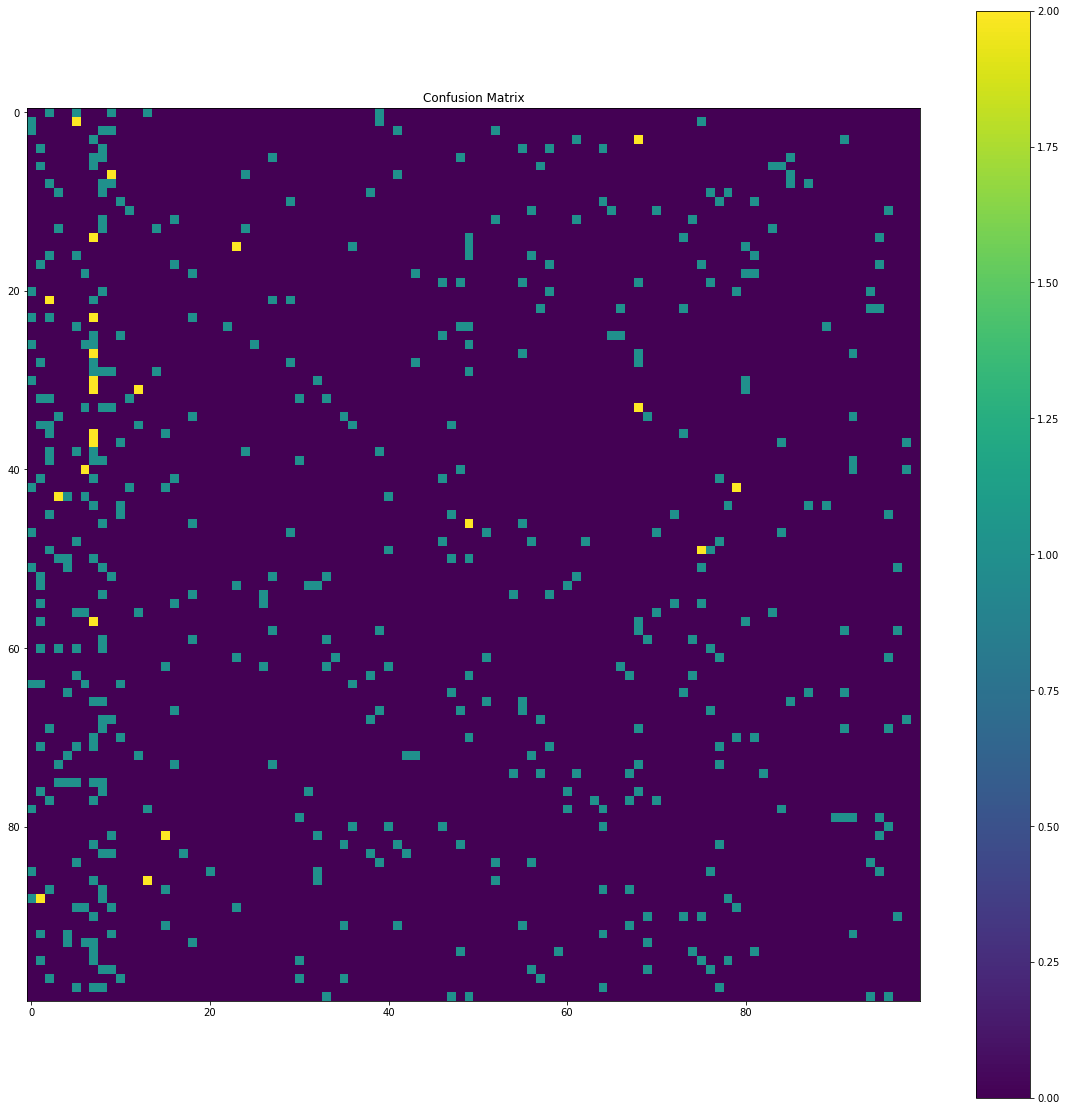

In [76]:
target_names = []
for key in train_generator.class_indices:
    target_names.append(key)

#Confution Matrix
Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(test_generator.classes, y_pred)
plt.plot(cm, target_names)
plt.figure(figsize=(20,20))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()

#Print Classification Report
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))